Yosuf Wakili - Credit Card Customer Segmentation Model - Unsupervised Machine Learning Classification

Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS

Read in dataset

In [3]:
df = pd.read_csv('purchases.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


Inspect data to find missing entries, data types of columns, and the unique values of each column

In [3]:
print(df.isnull().sum())
print(df.dtypes)
for column in df.columns:
    print(f"Unique values of {column}: {df[column].unique()}")

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                

After inspection we see that we can remove many columns that will not provide useful information to the analysis

In [4]:
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d',errors='coerce')

# Calculate age based on 'dob'
df['Age'] = 2024 - df['dob'].dt.year
df = df.drop(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant','category', 'city_pop', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'merch_zipcode', 'job', 'dob', 'is_fraud'], axis=1)
df.head()

,amt,gender,Age
0,4.97,F,36
1,107.23,F,46
2,220.11,M,62
3,45.00,M,57
4,41.96,M,38


One-hot encode categorical data

In [5]:
X = df

enc_X = pd.get_dummies(X, columns=['gender'], dtype=int)

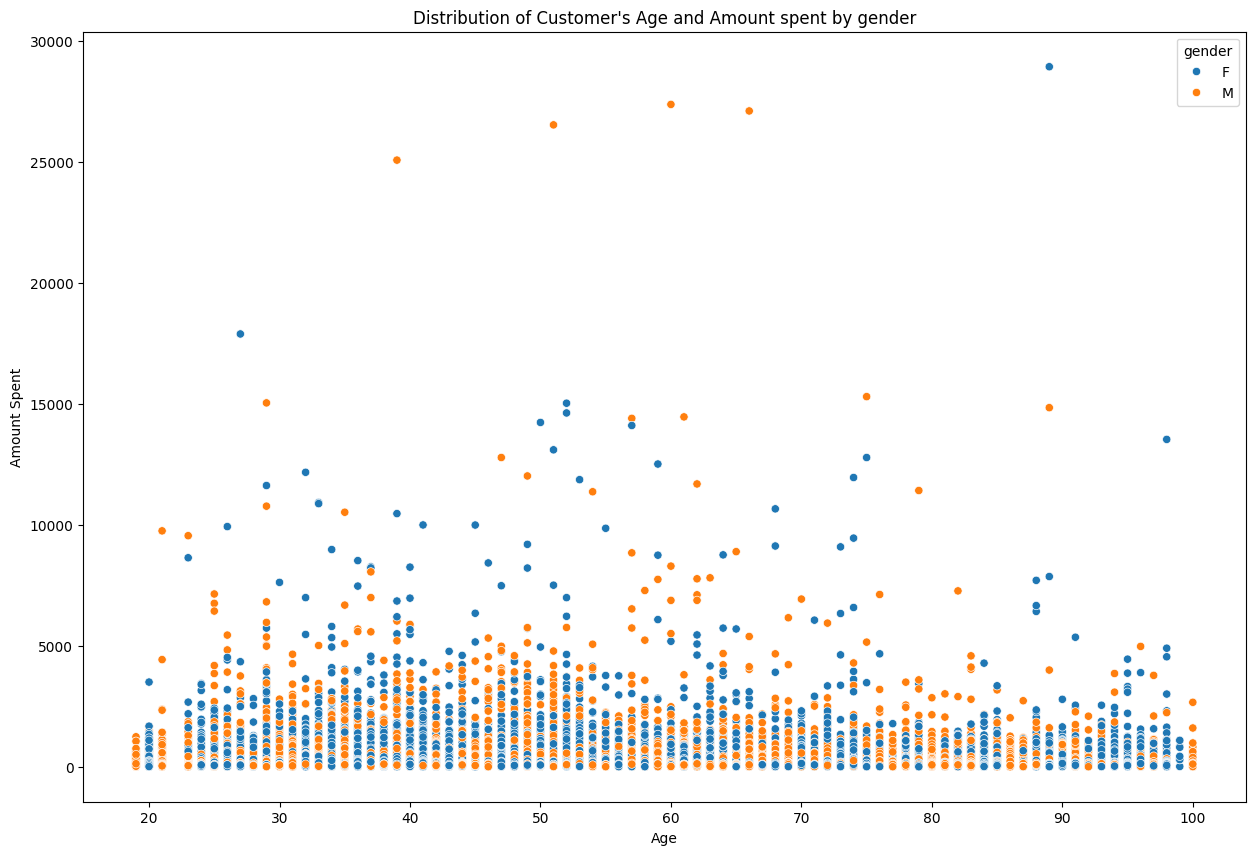

In [42]:
fig=plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x="Age", y="amt", hue="gender")
plt.title("Distribution of Customer's Age and Amount spent by gender")
plt.xlabel("Age")
plt.ylabel("Amount Spent")
plt.show()

Check data

In [5]:
enc_X = pd.DataFrame(enc_X)
print(enc_X)

            amt  Age  gender_F  gender_M
0          4.97   36         1         0
1        107.23   46         1         0
2        220.11   62         0         1
3         45.00   57         0         1
4         41.96   38         0         1
...         ...  ...       ...       ...
1296670   15.56   63         0         1
1296671   51.70   45         0         1
1296672  105.93   57         0         1
1296673   74.90   44         0         1
1296674    4.30   29         0         1

[1296675 rows x 4 columns]


Apply standard scaling to the data

In [6]:
std = StandardScaler()
std_X = std.fit_transform(enc_X)

Check the cumulative explained variance for different number of componenets to see if dimensionality can be reduced

Text(0, 0.5, 'cumulative explained variance')

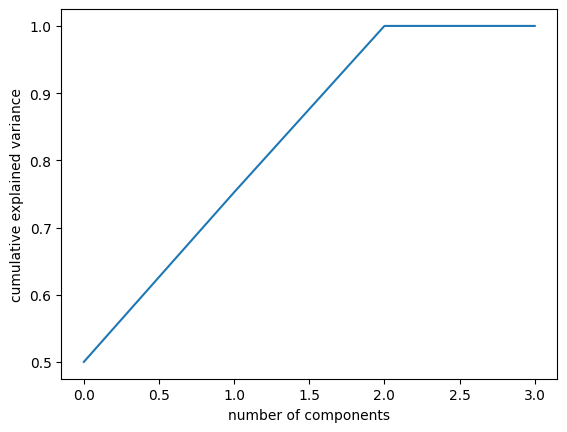

In [7]:
std_X = pd.DataFrame(std_X)
pca = IncrementalPCA().fit(std_X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

As seen from the graph, most componenets are needed for variance

In [7]:
pca = IncrementalPCA(n_components=2)
pca.fit_transform(std_X)

array([[-1.29232616, -0.82464985],
       [-1.28736458, -0.27175583],
       [ 1.56129478,  0.60406318],
       ...,
       [ 1.55824782,  0.34128466],
       [ 1.55271286, -0.39957   ],
       [ 1.54601391, -1.2468589 ]])

Set up OPTICS

In [84]:
optics = OPTICS(min_samples=20).fit(std_X.sample(frac=0.01, random_state=2020))

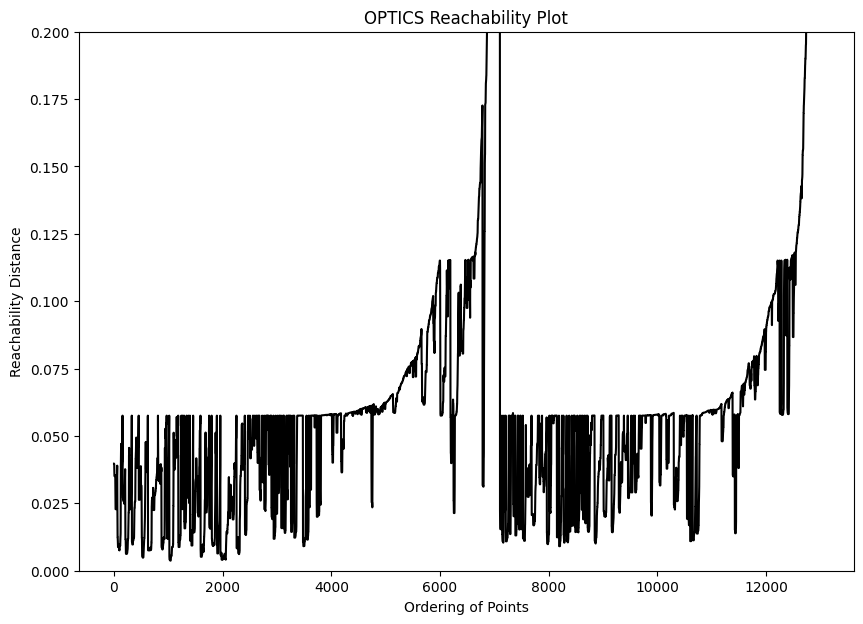

In [85]:
reachability = optics.reachability_[optics.ordering_]
space = np.arange(len(std_X.sample(frac=0.01, random_state=2020)))

# Plot reachability plot
plt.figure(figsize=(10, 7))
plt.ylim(top=0.2)
plt.plot(space, reachability, 'k-')
plt.xlabel('Ordering of Points')
plt.ylabel('Reachability Distance')
plt.title('OPTICS Reachability Plot')
plt.show()

<Axes: xlabel='1', ylabel='0'>

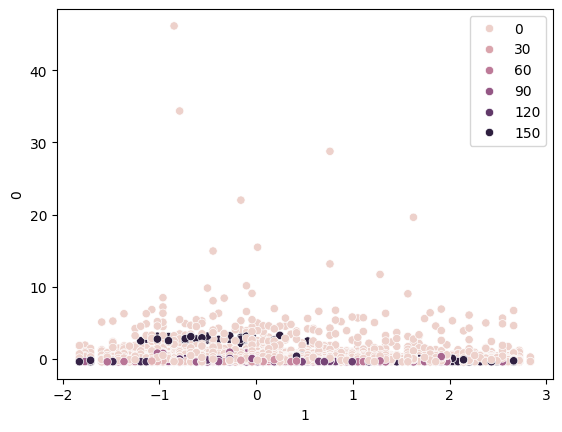

In [86]:
sns.scatterplot(data=std_X.sample(frac=0.01, random_state=2020), x=1,y=0, hue=optics.labels_)

In [88]:
cluster1 = std_X.iloc()[optics.ordering_[5500:6100]]
cluster2 = std_X.iloc()[optics.ordering_[11200:11300]]


cluster1 = std.inverse_transform(cluster1)
cluster2 = std.inverse_transform(cluster2)

amount1 = pd.DataFrame(cluster1)[0].mean()
amount2 = pd.DataFrame(cluster2)[0].mean()

age1 = pd.DataFrame(cluster1)[1].mean()
age2 = pd.DataFrame(cluster2)[1].mean()

genderF1 = pd.DataFrame(cluster1)[2].mean()
genderF2 = pd.DataFrame(cluster2)[2].mean()

genderM1 = pd.DataFrame(cluster1)[3].mean()
genderM2 = pd.DataFrame(cluster2)[3].mean()

print("Cluster near 10000 averages: ", "Amount: ", amount1, "Age:", age1, "Fraction Female:", genderF1, "Fraction Male: ", genderM1)
print("Cluster near 30000 averages: ", "Amount: ", amount2, "Age:", age2, "Fraction Female:", genderF2, "Fraction Male: ", genderM2)

Cluster near 10000 averages:  Amount:  65.77638333333334 Age: 50.711666666666666 Fraction Female: 0.555 Fraction Male:  0.445
Cluster near 30000 averages:  Amount:  100.38680000000001 Age: 56.26 Fraction Female: 0.54 Fraction Male:  0.46


Set up AgglomerativeClustering

In [19]:

agg = AgglomerativeClustering(linkage='single', compute_distances=True).fit(std_X.sample(frac = 0.1, random_state=2020))

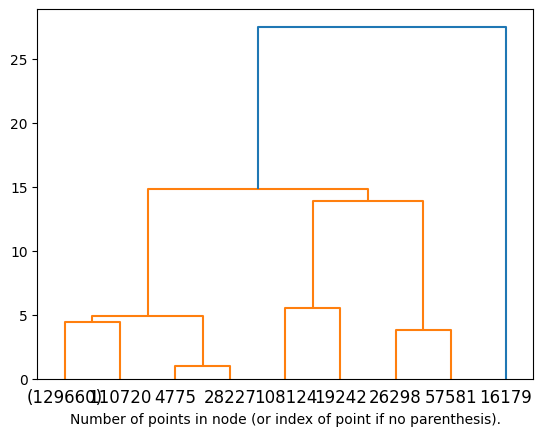

In [20]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(agg, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [9]:
std_X = pd.DataFrame(std_X)
agg2 = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(std_X.sample(frac = 0.01, random_state=2020))

<Axes: xlabel='1', ylabel='0'>

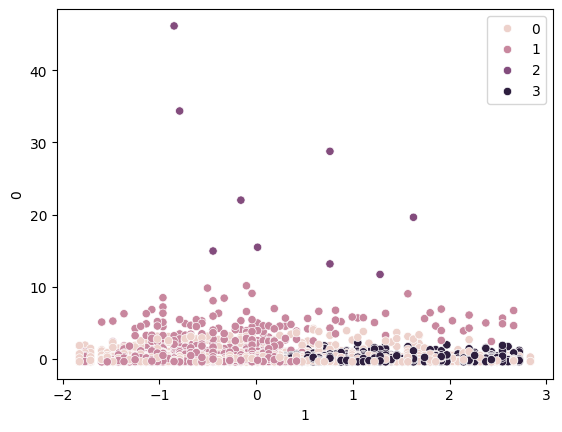

In [10]:
sns.scatterplot(data=std_X.sample(frac = 0.01, random_state=2020), x=1,y=0, hue=agg2.labels_)

Set up for MiniBatchKMeans clustering

Text(0.5, 1.0, 'Elbow curve')

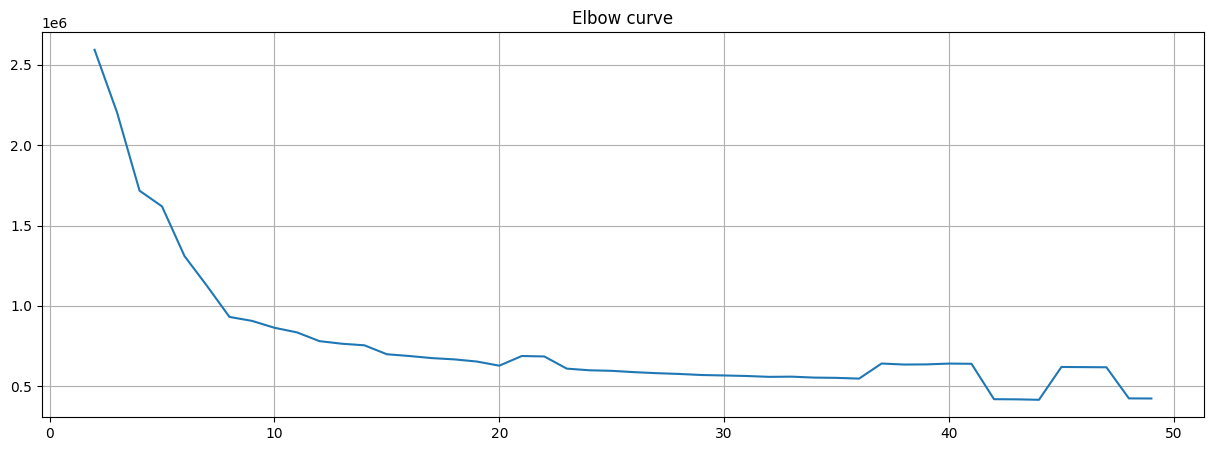

In [11]:
distorsions = []
for k in range(2, 50):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=2020, n_init="auto")
    kmeans.fit(std_X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 50), distorsions)
plt.grid(True)
plt.title('Elbow curve')

k=8 seems to be a good choice for the number of clusters

In [12]:
kmeans = MiniBatchKMeans(n_clusters=8, random_state=2020)
kmeans.fit_predict(std_X)

array([4, 1, 6, ..., 6, 6, 3], dtype=int32)

<Axes: xlabel='1', ylabel='0'>

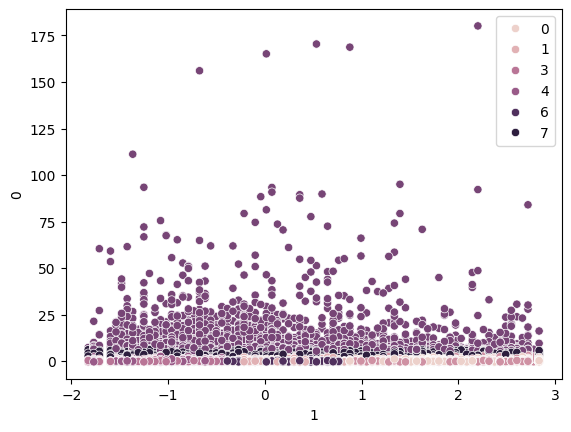

In [15]:
sns.scatterplot(data=std_X, x=1,y=0, hue=kmeans.labels_)